In [1]:
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import sup_func as sfu
import geograph_code as geo
import geopandas as gpd
import geocode as gc
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [2]:
df_covid.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3190534,"+54,026",225843.0,"+8,030",986706.0,1977985,60419.0,409.0,29.0,NaN,NaN
1,USA,1049431,"+13,666",60640.0,"+1,374",144411.0,844380,19110.0,3170.0,183.0,6043315.0,18258.0
2,Spain,236899,"+4,771",24275.0,+453,132929.0,79695,7764.0,5067.0,519.0,1414477.0,30253.0
3,Italy,203591,"+2,086",27682.0,+323,71252.0,104657,1795.0,3367.0,458.0,1910761.0,31603.0
4,France,165911,NaN,23660.0,NaN,46886.0,95365,4387.0,2542.0,362.0,463662.0,7103.0


In [3]:
df_covid[df_covid['Country,Other'] == 'Spain']

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
2,Spain,236899,"+4,771",24275.0,+453,132929.0,79695,7764.0,5067.0,519.0,1414477.0,30253.0


In [4]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame({'A' : []})
df_raw['Country (or dependency)'] = df_popu['Country (or dependency)']
df_raw['Population (2020)'] = df_popu['Population (2020)']
df_raw['Density (P/Km²)'] = df_popu['Density (P/Km²)']
df_raw['Land Area (Km²)'] = df_popu['Land Area (Km²)']
df_raw['Migrants (net)'] = df_popu['Migrants (net)']
df_raw['Med. Age'] = df_popu['Med. Age']
df_raw['Urban Pop %'] = df_popu['Urban Pop %']
df_raw = df_raw.dropna(how='all',axis=1)
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %
0,China,1439323776,153,9388211,-348399.0,38,61 %
1,India,1380004385,464,2973190,-532687.0,28,35 %
2,United States,331002651,36,9147420,954806.0,38,83 %
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %
4,Pakistan,220892340,287,770880,-233379.0,23,35 %


In [5]:

#After checking both countries columns, I try match both columns with below dictionary
country_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}
df_covid['Country (or dependency)'] = df_covid['Country,Other']
df_covid.replace({'Country (or dependency)': country_dic},  inplace = True)
#I remove the columns from df_covid that I am not interested in 
df_subs = df_covid.drop([df_covid.columns[8],'Country,Other','NewCases','NewDeaths','ActiveCases','Serious,Critical','Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_subs.head()

,TotalCases,TotalDeaths,TotalRecovered,TotalTests,Country (or dependency)
0,3190534,225843.0,986706.0,NaN,World
1,1049431,60640.0,144411.0,6043315.0,United States
2,236899,24275.0,132929.0,1414477.0,Spain
3,203591,27682.0,71252.0,1910761.0,Italy
4,165911,23660.0,46886.0,463662.0,France


In [6]:
#I join both tables using as index the country
df_raw = df_raw.join(df_subs.set_index('Country (or dependency)'), on='Country (or dependency)')
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests
0,China,1439323776,153,9388211,-348399.0,38,61 %,82858.0,4633.0,77578.0,NaN
1,India,1380004385,464,2973190,-532687.0,28,35 %,31787.0,1008.0,7796.0,770764.0
2,United States,331002651,36,9147420,954806.0,38,83 %,1049431.0,60640.0,144411.0,6043315.0
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %,9771.0,784.0,1391.0,86985.0
4,Pakistan,220892340,287,770880,-233379.0,23,35 %,15525.0,343.0,3425.0,165911.0


In [7]:
#I have called dtypes to check where I have non-numeric columns to change its type.
df_raw.dtypes

Country (or dependency)     object
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                    object
Urban Pop %                 object
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [8]:
#lets start for Urban POP, I change % values to floats, 100% is 1 0% is 0
indexes = df_raw.index.values.tolist()
for index in indexes:
    per = df_raw.loc[index,'Urban Pop %']
    if per == 'N.A.':
        df_raw.loc[index,'Urban Pop %'] = np.nan
    else:
        if type(per) is str:
            if per == '0 %':
                df_raw.loc[index,'Urban Pop %'] = 0
            else:
                df_raw.loc[index,'Urban Pop %'] = int(per[0:2])/100

df_raw = df_raw.astype({'Urban Pop %': 'float64'})
#Now I change the countries name to a number and replace the name with the number in the df
countries_list = df_raw['Country (or dependency)'].unique()
countries_list.sort()
countries_dic = dict()
k=0
for country in countries_list:
    countries_dic[country] = k
    k +=1
dic_reverse = {}
for key,values in countries_dic.items():
    dic_reverse[values] = key

df_raw.replace({'Country (or dependency)': countries_dic},  inplace = True)
#the last one is the Med Age. I change to a numeric, using coerce (imput NAN to errors)
df_raw['Med. Age'] = pd.to_numeric(df_raw['Med. Age'],errors='coerce')
df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [9]:
#I am going to add a column of countries with free healthcare, migth be usefull
df_healthcare = pd.read_csv('countries with free healthcare.csv')
hc_edit = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}
df_healthcare.replace({'name': hc_edit},  inplace = True)
df_healthcare['Free healthcare'] = 1
df_healthcare.drop(['pop2020'], axis=1, inplace=True)
df_healthcare.replace({'name': countries_dic},  inplace = True)
df_healthcare.head()

,name,Free healthcare
0,1,1
1,2,1
2,4,1
3,7,1
4,8,1


In [10]:
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country (or dependency)')
df_raw['Free healthcare'].fillna(0, inplace=True)

#now I am ready with my df, everything is a number

df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
Free healthcare            float64
dtype: object

In [11]:
df_raw = df_raw[['Country (or dependency)','Population (2020)','Density (P/Km²)','Migrants (net)','Med. Age',
                 'Urban Pop %','Free healthcare','TotalCases','TotalDeaths','TotalRecovered','TotalTests']]
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Migrants (net),Med. Age,Urban Pop %,Free healthcare,TotalCases,TotalDeaths,TotalRecovered,TotalTests
0,43,1439323776,153,-348399.0,38.0,0.61,1.0,82858.0,4633.0,77578.0,NaN
1,96,1380004385,464,-532687.0,28.0,0.35,0.0,31787.0,1008.0,7796.0,770764.0
2,224,331002651,36,954806.0,38.0,0.83,0.0,1049431.0,60640.0,144411.0,6043315.0
3,97,273523615,151,-98955.0,30.0,0.56,0.0,9771.0,784.0,1391.0,86985.0
4,158,220892340,287,-233379.0,23.0,0.35,1.0,15525.0,343.0,3425.0,165911.0


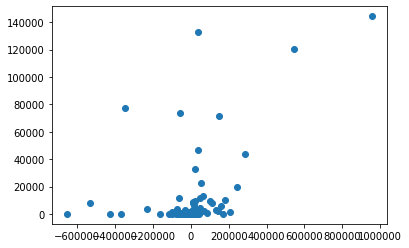

In [12]:
equis = df_raw['Migrants (net)']
ygriega = df_raw['TotalRecovered']
#mymodel = np.poly1d(np.polyfit(equis, ygriega, 3))

#myline = np.linspace(0, 1, 100)
plt.scatter(equis, ygriega)
#plt.plot(myline, mymodel(myline))
plt.show()

In [13]:
#3 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
casos = ['TotalCases','TotalDeaths','TotalRecovered']
for caso in casos:
    X, y = sfu.edit_df(df_raw,caso)
    r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)
    print("{} case: The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(caso,r2_scores_train,r2_scores_test))
    

TotalCases case: The rsquared on the training data was 0.8447498807082984.  The rsquared on the test data was 0.3054985090715594.
TotalDeaths case: The rsquared on the training data was 0.29449044758532184.  The rsquared on the test data was 0.6004735798440446.
TotalRecovered case: The rsquared on the training data was 0.5615845752340344.  The rsquared on the test data was 0.6662842259640016.


In [14]:
casos = ['TotalCases','TotalDeaths','TotalRecovered']
for caso in casos:
    X, y = sfu.edit_df(df_raw,caso)
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X, y)
    y_preds = lm_model.predict(X)
    rsquared_score = r2_score(y, y_preds)
    print("{} case: The rsquared on data was {}.".format(caso,rsquared_score))
    
    '''- if  R-squared value < 0.3 this value is generally considered a None or Very weak effect size,
- if R-squared value 0.3 < r < 0.5 this value is generally considered a weak or low effect size,
- if R-squared value 0.5 < r < 0.7 this value is generally considered a Moderate effect size,
- if R-squared value r > 0.7 this value is generally considered strong effect size,'''

TotalCases case: The rsquared on data was 0.8182678575928106.
TotalDeaths case: The rsquared on data was 0.6382995406822061.
TotalRecovered case: The rsquared on data was 0.5954327862479636.


In [15]:
X, y = sfu.edit_df(df_raw, 'TotalRecovered')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
5,Urban Pop %,2293.291294,2293.291294
6,Free healthcare,1209.991165,1209.991165
4,Med. Age,215.966140,215.966140
0,Country (or dependency),-3.219703,3.219703
2,Density (P/Km²),-0.149103,0.149103
7,TotalTests,0.017906,0.017906
3,Migrants (net),0.017709,0.017709
1,Population (2020),0.000031,0.000031


In [16]:
X, y = sfu.edit_df(df_raw, 'TotalCases')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Free healthcare,-9159.474778,9159.474778
5,Urban Pop %,-5166.578781,5166.578781
4,Med. Age,-153.436048,153.436048
0,Country (or dependency),-3.200614,3.200614
2,Density (P/Km²),1.090749,1.090749
3,Migrants (net),0.225458,0.225458
7,TotalTests,0.103144,0.103144
1,Population (2020),0.000094,0.000094


In [17]:
X, y = sfu.edit_df(df_raw, 'TotalDeaths')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
5,Urban Pop %,6.032167e+02,6.032167e+02
4,Med. Age,7.109495e+01,7.109495e+01
6,Free healthcare,1.555312e+01,1.555312e+01
0,Country (or dependency),-3.076603e+00,3.076603e+00
2,Density (P/Km²),-2.340448e-01,2.340448e-01
7,TotalTests,4.472505e-03,4.472505e-03
3,Migrants (net),2.674592e-05,2.674592e-05
1,Population (2020),7.376430e-07,7.376430e-07


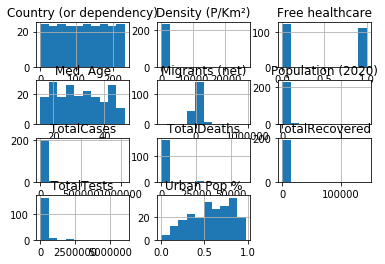

In [18]:
df_raw.hist();

In [19]:
df_corr = df_raw.corr()
df_corr = df_corr[['Density (P/Km²)','Med. Age', 'Urban Pop %','Migrants (net)', 'Free healthcare']]
df_corre = df_corr.drop(['Country (or dependency)','Population (2020)','Density (P/Km²)','Migrants (net)','Med. Age','Urban Pop %','Urban Pop %', 'Free healthcare'],axis=0)
df_corre

,Density (P/Km²),Med. Age,Urban Pop %,Migrants (net),Free healthcare
TotalCases,-0.027436,0.183122,0.155045,0.608754,0.049599
TotalDeaths,-0.029631,0.214085,0.163556,0.543379,0.065082
TotalRecovered,-0.038502,0.261938,0.182900,0.459749,0.159419
TotalTests,-0.034066,0.243437,0.182490,0.626716,0.100672


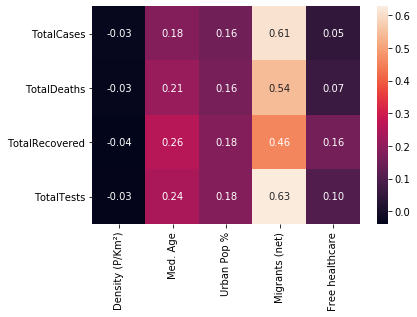

In [20]:
sns.heatmap(df_corre, annot= True, fmt='.2f');
#plt.savefig('heatmap.png')

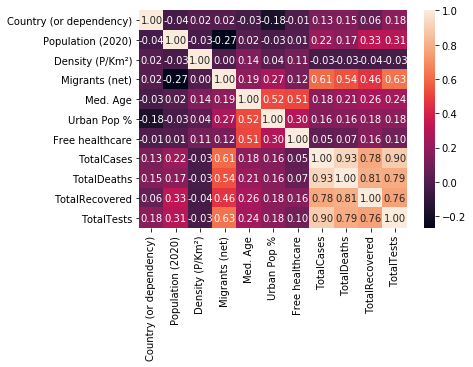

In [21]:
sns.heatmap(df_raw.corr(), annot= True, fmt='.2f');


In [22]:

dic_fh = {1: 'Yes', 0:'No'}


In [23]:
df_c = pd.DataFrame()

In [24]:
df_c['Free Healthcare'] = df_raw['Free healthcare']
df_c.replace({'Free Healthcare':dic_fh}, inplace = True)
df_c['Population (2020)'] = df_raw['Population (2020)']
group_dfc2 = df_c.groupby('Free Healthcare').agg({'count','sum'})
df_c['TotalCases'] = df_raw['TotalCases']
df_c['TotalDeaths'] = df_raw['TotalDeaths']
df_c['TotalRecovered'] = df_raw['TotalRecovered']
df_c['TotalTests'] = df_raw['TotalTests']
group_dfc = df_c.groupby('Free Healthcare').sum()
group_dfc['Tests per 1M P']= (group_dfc['TotalTests']*1e6)/group_dfc['Population (2020)']
group_dfc['Cases per 1M P']= (group_dfc['TotalCases']*1e6)/group_dfc['Population (2020)']
group_dfc['Deaths per 100 Cases'] = (group_dfc['TotalDeaths']*100)/group_dfc['TotalCases']
group_dfc['Recovered per 100 Cases'] = (group_dfc['TotalRecovered']*100)/group_dfc['TotalCases']
group_dfc['Deaths per 1M P'] = (group_dfc['TotalDeaths']*1e6)/group_dfc['Population (2020)']
group_dfc['Recovered per 1M P'] = (group_dfc['TotalRecovered']*1e6)/group_dfc['Population (2020)']
rate_expected = group_dfc.loc['No','Cases per 1M P']/group_dfc.loc['Yes','Cases per 1M P']
death_rate = group_dfc.loc['No','Deaths per 100 Cases']/group_dfc.loc['Yes','Deaths per 100 Cases']
expected_deaths = group_dfc.loc['Yes','Deaths per 100 Cases']*rate_expected
expected_recovered =  group_dfc.loc['Yes','Recovered per 100 Cases']*death_rate
"We might expect {} deaths per each 100 cases in countries with no free Healthcare, however we see 5.55 per 100 Cases. Also, we might expect {} recovered cases per each 100 using the previous rate, but again we find  15.3 recovered cases only per each 100.".format(expected_deaths,expected_recovered)

'We might expect 4.54790777507219 deaths per each 100 cases in countries with no free Healthcare, however we see 5.55 per 100 Cases. Also, we might expect 28.20284376022731 recovered cases per each 100 using the previous rate, but again we find  15.3 recovered cases only per each 100.'

In [25]:


df_new = pd.DataFrame()
df_new['Tests per 1M P']=group_dfc['Tests per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Cases per 1M P']=group_dfc['Cases per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Deaths per 1M P']=group_dfc['Deaths per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Case Recovery rate']=group_dfc['Recovered per 100 Cases'].apply(lambda x: "{0:.2f}%".format(x))
df_new['Case fatality rate']=group_dfc['Deaths per 100 Cases'].apply(lambda x: "{0:.2f}%".format(x))
df_new



,Tests per 1M P,Cases per 1M P,Deaths per 1M P,Case Recovery rate,Case fatality rate
Free Healthcare,,,,,
No,2194.79,299.10,16.74,15.36%,5.60%
Yes,5851.92,523.35,41.65,40.10%,7.96%


(0, 160)

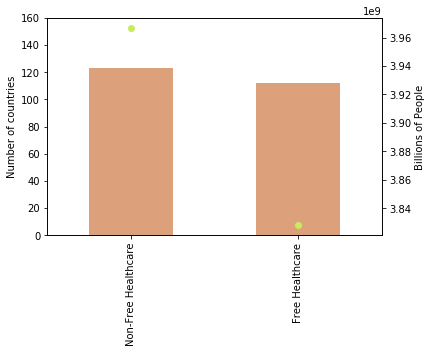

In [26]:

index = ['Non-Free Healthcare','Free Healthcare']
df_p = pd.DataFrame(index=index)
df_p['Countries'] = [group_dfc2[('Population (2020)', 'count')][0],group_dfc2[('Population (2020)', 'count')][1]]
df_p['Population'] = [group_dfc2[('Population (2020)', 'sum')][0],group_dfc2[('Population (2020)', 'sum')][1]]

fig = plt.figure(figsize=(6, 4)) # Create matplotlib figure


ax = fig.add_subplot() # Create matplotlib axes
ax = df_p['Countries'].plot(kind='bar', color='#dca07b', use_index=True)
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax2.plot(ax.get_xticks(),
         df_p['Population'].values,
         linestyle=' ',
         marker='o', color='#c5ed5a')
ax.set_ylabel('Number of countries')
ax2.set_ylabel('Billions of People')

ax.set_ylim((0, 160))



#ax2.xaxis.set_major_formatter(billi)



In [27]:

df_p['Population'] = df_p['Population'].apply(lambda x: "{0:.2f}B".format(x * 1e-9))


In [28]:
df_p


,Countries,Population
Non-Free Healthcare,123,3.97B
Free Healthcare,112,3.83B


In [29]:
df_raw['Med. Age'].fillna(round((df_raw['Med. Age'].mean()),0), inplace=True)




In [30]:
df_raw['rank age'] = df_raw['Med. Age'].apply(sfu.age_rank)
df_raw

,Country (or dependency),Population (2020),Density (P/Km²),Migrants (net),Med. Age,Urban Pop %,Free healthcare,TotalCases,TotalDeaths,TotalRecovered,TotalTests,rank age
0,43,1439323776,153,-348399.0,38.0,0.61,1.0,82858.0,4633.0,77578.0,NaN,35-40
1,96,1380004385,464,-532687.0,28.0,0.35,0.0,31787.0,1008.0,7796.0,770764.0,<=30
2,224,331002651,36,954806.0,38.0,0.83,0.0,1049431.0,60640.0,144411.0,6043315.0,35-40
3,97,273523615,151,-98955.0,30.0,0.56,0.0,9771.0,784.0,1391.0,86985.0,<=30
4,158,220892340,287,-233379.0,23.0,0.35,1.0,15525.0,343.0,3425.0,165911.0,<=30
...,...,...,...,...,...,...,...,...,...,...,...,...
230,139,4992,50,NaN,31.0,0.10,0.0,11.0,1.0,2.0,36.0,30-35
231,69,3480,0,NaN,31.0,0.66,0.0,13.0,NaN,11.0,353.0,30-35
232,152,1626,6,NaN,31.0,0.46,1.0,NaN,NaN,NaN,NaN,30-35
233,211,1357,136,NaN,31.0,0.00,0.0,NaN,NaN,NaN,NaN,30-35


In [39]:
df_cha = pd.DataFrame()

df_cha['Age Rank']=df_raw['rank age'] 
df_cha['TotalCases']=df_raw['TotalCases']
df_cha['Population (2020)']=df_raw['Population (2020)']



df_g= df_cha.groupby(['Age Rank']).agg(['sum','count'])


#rango 1 de 38 a 48
#rango 2 31 a 33
#rango 3 24 a 30
# rango 4 23 a 15

TotalCases       Population (2020)      
                sum count               sum count
Age Rank                                         
30-35      405653.0    52         783037906    65
35-40     1467399.0    25        2132111871    25
40-45      715711.0    34         479332611    36
<=30       195524.0    93        4108599094   103
>45        405526.0     6         291717257     6

In [41]:
df_g['Number of Countries'] = df_g[('TotalCases','count')]
df_g['Cases per 1M P'] = (df_g[('TotalCases','sum')])*1e6/df_g[('Population (2020)','sum')]
df_g = df_g.drop([('TotalCases','sum'),('TotalCases','count'),('Population (2020)','sum'),('Population (2020)','count')],axis=1)

In [46]:

df_g=df_g.iloc[[4,2,1,0,3],[0,1]]
df_g

,Number of Countries,Cases per 1M P
,,
Age Rank,,
>45,6,1390.133735
40-45,34,1493.140637
35-40,25,688.237339
30-35,52,518.050272
<=30,93,47.588970


Text(0, 0.5, 'Number of countries')

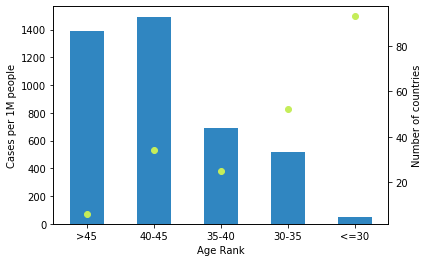

In [48]:
ax = df_g['Cases per 1M P'].plot.bar(rot=0,color='#3086c1')
ax2 = ax.twinx()

ax2.plot(ax.get_xticks(),
         df_g['Number of Countries'].values,
         linestyle=' ',
         marker='o', color='#c5ed5a')

ax.set_ylabel('Cases per 1M people')
ax2.set_ylabel('Number of countries')



In [49]:
# set the filepath and load
fp = 'World_Countries.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


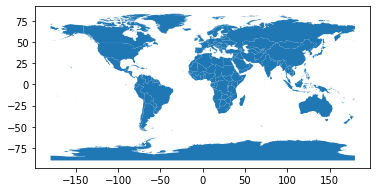

In [50]:
map_df.plot()

In [51]:
df = gpd.read_file(fp)

In [52]:
df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [53]:
data_for_map = df.rename(index=str, columns={'COUNTRY': 'COUNTRY', 'geometry': 'geometry'})

In [54]:
df_raw['Country'] = df_raw['Country (or dependency)']
df_raw.replace({'Country': dic_reverse},  inplace = True)


In [55]:
arr_dict = {'Afghanistan':'Afghanistan',
'Albania':'Albania',
'Algeria':'Algeria',
'American Samoa':'American Samoa (US)',
'Andorra':'Andorra',
'Angola':'Angola',
'Anguilla':'Anguilla (UK)',
'Antigua and Barbuda':'Antigua and Barbuda',
'Argentina':'Argentina',
'Armenia':'Armenia',
'Aruba':'Aruba (Netherlands)',
'Australia':'Australia',
'Austria':'Austria',
'Azerbaijan':'Azerbaijan',
'Bahamas':'Bahamas',
'Bahrain':'Bahrain',
'Bangladesh':'Bangladesh',
'Barbados':'Barbados',
'Belarus':'Belarus',
'Belgium':'Belgium',
'Belize':'Belize',
'Benin':'Benin',
'Bermuda':'Bermuda (UK)',
'Bhutan':'Bhutan',
'Bolivia':'Bolivia',
'Bosnia and Herzegovina':'Bosnia and Herzegovina',
'Botswana':'Botswana',
'Brazil':'Brazil',
'British Virgin Islands':'British Virgin Islands(UK)',
'Brunei':'Brunei',
'Bulgaria':'Bulgaria',
'Burkina Faso':'Burkina Faso',
'Burundi':'Burundi',
'Cabo Verde':'Cape Verde',
'Cambodia':'Cambodia',
'Cameroon':'Cameroon',
'Canada':'Canada',
'Caribbean Netherlands':'Netherlands',
'Cayman Islands':'Cayman Islands (UK)',
'Central African Republic':'Central African Republic',
'Chad':'Chad',
'Channel Islands':'Channel Islands',
'Chile':'Chile',
'China':'China',
'Colombia':'Colombia',
'Comoros':'Comoros',
'Congo':'Congo',
'Cook Islands':'Cook Islands (New Zealand)',
'Costa Rica':'Costa Rica',
"Côte d'Ivoire":'Ivory Coast',
'Croatia':'Croatia',
'Cuba':'Cuba',
'Curaçao':'Curacao (Netherlands)',
'Cyprus':'Cyprus',
'Czech Republic (Czechia)':'Czech Republic',
'Denmark':'Denmark',
'Djibouti':'Djibouti',
'Dominica':'Dominica',
'Dominican Republic':'Dominican Republic',
'DR Congo':'Democratic Republic of the Congo',
'Ecuador':'Ecuador',
'Egypt':'Egypt',
'El Salvador':'El Salvador',
'Equatorial Guinea':'Equatorial Guinea',
'Eritrea':'Eritrea',
'Estonia':'Estonia',
'Eswatini':'Swaziland',
'Ethiopia':'Ethiopia',
'Faeroe Islands':'Faroe Islands (Denmark)',
'Falkland Islands':'Falkland Islands (UK)',
'Fiji':'Fiji',
'Finland':'Finland',
'France':'France',
'French Guiana':'French Guiana (France)',
'French Polynesia':'French Polynesia (France)',
'Gabon':'Gabon',
'Gambia':'Gambia',
'Georgia':'Georgia',
'Germany':'Germany',
'Ghana':'Ghana',
'Gibraltar':'Gibraltar (UK)',
'Greece':'Greece',
'Greenland':'Greenland (Denmark)',
'Grenada':'Grenada',
'Guadeloupe':'Guadeloupe (France)',
'Guam':'Guam (US)',
'Guatemala':'Guatemala',
'Guinea':'Guinea',
'Guinea-Bissau':'Guinea-Bissau',
'Guyana':'Guyana',
'Haiti':'Haiti',
'Holy See':'Holy See',
'Honduras':'Honduras',
'Hong Kong':'Hong Kong',
'Hungary':'Hungary',
'Iceland':'Iceland',
'India':'India',
'Indonesia':'Indonesia',
'Iran':'Iran',
'Iraq':'Iraq',
'Ireland':'Ireland',
'Isle of Man':'Isle of Man (UK)',
'Israel':'Israel',
'Italy':'Italy',
'Jamaica':'Jamaica',
'Japan':'Japan',
'Jordan':'Jordan',
'Kazakhstan':'Kazakhstan',
'Kenya':'Kenya',
'Kiribati':'Kiribati',
'Kuwait':'Kuwait',
'Kyrgyzstan':'Kyrgyzstan',
'Laos':'Laos',
'Latvia':'Latvia',
'Lebanon':'Lebanon',
'Lesotho':'Lesotho',
'Liberia':'Liberia',
'Libya':'Libya',
'Liechtenstein':'Liechtenstein',
'Lithuania':'Lithuania',
'Luxembourg':'Luxembourg',
'Macao':'Macao',
'Madagascar':'Madagascar',
'Malawi':'Malawi',
'Malaysia':'Malaysia',
'Maldives':'Maldives',
'Mali':'Mali',
'Malta':'Malta',
'Marshall Islands':'Marshall Islands',
'Martinique':'Martinique (France)',
'Mauritania':'Mauritania',
'Mauritius':'Mauritius',
'Mayotte':'Mayotte (France)',
'Mexico':'Mexico',
'Micronesia':'Federated States of Micronesia',
'Moldova':'Moldova',
'Monaco':'Monaco',
'Mongolia':'Mongolia',
'Montenegro':'Montenegro',
'Montserrat':'Montserrat',
'Morocco':'Morocco',
'Mozambique':'Mozambique',
'Myanmar':'Myanmar',
'Namibia':'Namibia',
'Nauru':'Nauru',
'Nepal':'Nepal',
'Netherlands':'Netherlands',
'New Caledonia':'New Caledonia (France)',
'New Zealand':'New Zealand',
'Nicaragua':'Nicaragua',
'Niger':'Niger',
'Nigeria':'Nigeria',
'Niue':'Niue (New Zealand)',
'North Korea':'North Korea',
'North Macedonia':'Macedonia',
'Northern Mariana Islands':'Northern Mariana Islands (US)',
'Norway':'Norway',
'Oman':'Oman',
'Pakistan':'Pakistan',
'Palau':'Palau (US)',
'Panama':'Panama',
'Papua New Guinea':'Papua New Guinea',
'Paraguay':'Paraguay',
'Peru':'Peru',
'Philippines':'Philippines',
'Poland':'Poland',
'Portugal':'Portugal',
'Puerto Rico':'Puerto Rico (US)',
'Qatar':'Qatar',
'Réunion':'Reunion (France)',
'Romania':'Romania',
'Russia':'Russia',
'Rwanda':'Rwanda',
'Saint Barthelemy':'Saint Barthelemy',
'Saint Helena':'St. Helena (UK)',
'Saint Kitts & Nevis':'St. Kitts and Nevis',
'Saint Lucia':'St. Lucia',
'Saint Martin':'Saint Martin',
'Saint Pierre & Miquelon':'St. Pierre and Miquelon (France)',
'Samoa':'Western Samoa',
'San Marino':'San Marino',
'Sao Tome & Principe':'Sao Tome and Principe',
'Saudi Arabia':'Saudi Arabia',
'Senegal':'Senegal',
'Serbia':'Serbia',
'Seychelles':'Seychelles',
'Sierra Leone':'Sierra Leone',
'Singapore':'Singapore',
'Sint Maarten':'Sint Maarten',
'Slovakia':'Slovakia',
'Slovenia':'Slovenia',
'Solomon Islands':'Solomon Islands',
'Somalia':'Somalia',
'South Africa':'South Africa',
'South Korea':'South Korea',
'South Sudan':'South Sudan',
'Spain':'Spain',
'Sri Lanka':'Sri Lanka',
'St. Vincent & Grenadines':'St. Vincent and the Grenadines',
'State of Palestine':'Palestine',
'Sudan':'Sudan',
'Suriname':'Suriname',
'Sweden':'Sweden',
'Switzerland':'Switzerland',
'Syria':'Syria',
'Taiwan':'Taiwan',
'Tajikistan':'Tajikistan',
'Tanzania':'Tanzania',
'Thailand':'Thailand',
'Timor-Leste':'East Timor',
'Togo':'Togo',
'Tokelau':'Tokelau (New Zealand)',
'Tonga':'Tonga',
'Trinidad and Tobago':'Trinidad and Tobago',
'Tunisia':'Tunisia',
'Turkey':'Turkey',
'Turkmenistan':'Turkmenistan',
'Turks and Caicos':'Turks and Caicos Islands (UK)',
'Tuvalu':'Tuvalu',
'U.S. Virgin Islands':'American Virgin Islands (US)',
'Uganda':'Uganda',
'Ukraine':'Ukraine',
'United Arab Emirates':'United Arab Emirates',
'United Kingdom':'United Kingdom',
'United States':'United States',
'Uruguay':'Uruguay',
'Uzbekistan':'Uzbekistan',
'Vanuatu':'Vanuatu',
'Venezuela':'Venezuela',
'Vietnam':'Vietnam',
'Wallis & Futuna':'Wallis and Futuna (France)',
'Western Sahara':'Western Sahara',
'Yemen':'Yemen',
'Zambia':'Zambia',
'Zimbabwe':'Zimbabwe'}

In [56]:
df_raw.replace({'Country': arr_dict},  inplace = True)

In [57]:
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Migrants (net),Med. Age,Urban Pop %,Free healthcare,TotalCases,TotalDeaths,TotalRecovered,TotalTests,rank age,Country
0,43,1439323776,153,-348399.0,38.0,0.61,1.0,82858.0,4633.0,77578.0,NaN,35-40,China
1,96,1380004385,464,-532687.0,28.0,0.35,0.0,31787.0,1008.0,7796.0,770764.0,<=30,India
2,224,331002651,36,954806.0,38.0,0.83,0.0,1049431.0,60640.0,144411.0,6043315.0,35-40,United States
3,97,273523615,151,-98955.0,30.0,0.56,0.0,9771.0,784.0,1391.0,86985.0,<=30,Indonesia
4,158,220892340,287,-233379.0,23.0,0.35,1.0,15525.0,343.0,3425.0,165911.0,<=30,Pakistan


In [58]:
dfh = pd.DataFrame()
dfh['Country'] = df_raw['Country']
dfh['Free healthcare'] = df_raw['Free healthcare']
dfh['TotalCases'] = df_raw['TotalCases']
dfh['Population (2020)'] = df_raw['Population (2020)']
dfh['TotalDeaths'] = df_raw['TotalDeaths']
dfh['TotalDeaths'].fillna(0, inplace=True)
dfh['Cases per 1M P']=(dfh['TotalCases']*1e6)/dfh['Population (2020)']
dfh['Deaths per 100 cases'] = (dfh['TotalDeaths']*100)/dfh['TotalCases']
dfh['Deaths per 1M P'] =(dfh['TotalDeaths']*1e6)/dfh['Population (2020)']
dfh['Deaths per 1M P'].fillna(0, inplace=True)
dfh['TotalCases'].fillna(0, inplace=True)
dfh['Deaths per 100 cases'].fillna(0, inplace=True)
dfh['Cases per 1M P'].fillna(0, inplace=True)
dfh.isnull().mean()

Country                 0.0
Free healthcare         0.0
TotalCases              0.0
Population (2020)       0.0
TotalDeaths             0.0
Cases per 1M P          0.0
Deaths per 100 cases    0.0
Deaths per 1M P         0.0
dtype: float64

In [59]:
merged = map_df.set_index('COUNTRY').join(dfh.set_index('Country'))

In [60]:
merged.head()

,geometry,Free healthcare,TotalCases,Population (2020),TotalDeaths,Cases per 1M P,Deaths per 100 cases,Deaths per 1M P
Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.0,1939.0,38928346.0,60.0,49.809463,3.094379,1.541293
Albania,"POLYGON ((20.79192 40.43154, 20.78722 40.39472...",1.0,766.0,2877797.0,30.0,266.175828,3.916449,10.424641
Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236...",1.0,3848.0,43851044.0,444.0,87.751617,11.538462,10.125187
American Samoa (US),"POLYGON ((-170.74390 -14.37556, -170.74942 -14...",0.0,0.0,55191.0,0.0,0.000000,0.000000,0.000000
American Virgin Islands (US),"POLYGON ((-64.89612 17.67667, -64.89140 17.683...",0.0,0.0,104425.0,0.0,0.000000,0.000000,0.000000


C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


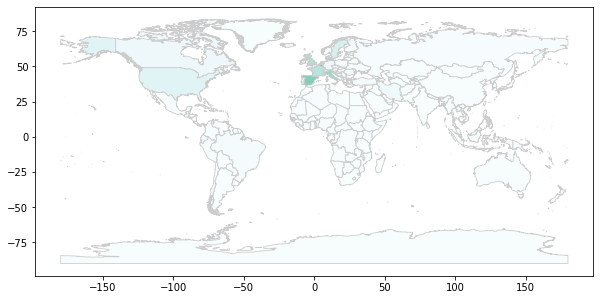

In [61]:
variable = 'Deaths per 1M P'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')

In [62]:
ax.axis('off')# add a title
ax.set_title('Deaths per 1M P', fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: worldometers.info',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

Text(0.1, 0.08, 'Source: worldometers.info')

In [63]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format('Deaths per 1M P'), dpi=300)

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


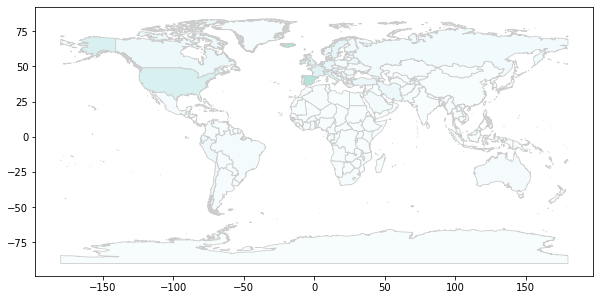

In [64]:
variable = 'Cases per 1M P'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')

In [65]:
ax.axis('off')# add a title
ax.set_title(variable, fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: worldometers.info',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

Text(0.1, 0.08, 'Source: worldometers.info')

In [66]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format(variable), dpi=300)

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


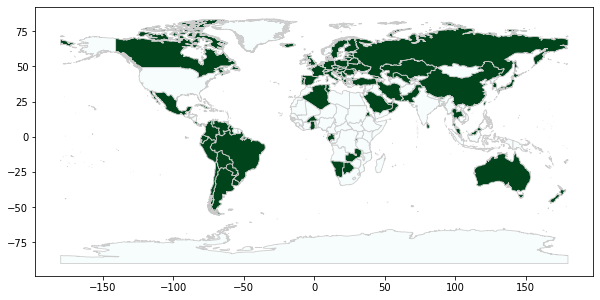

In [67]:
variable = 'Free healthcare'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')


In [68]:
ax.axis('off')# add a title
ax.set_title('Countries with ' + variable, fontdict={'fontsize': '15', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: https://worldpopulationreview.com/',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

Text(0.1, 0.08, 'Source: https://worldpopulationreview.com/')

In [69]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format(variable), dpi=300)